# Import Libraries

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the Data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Plot Examples

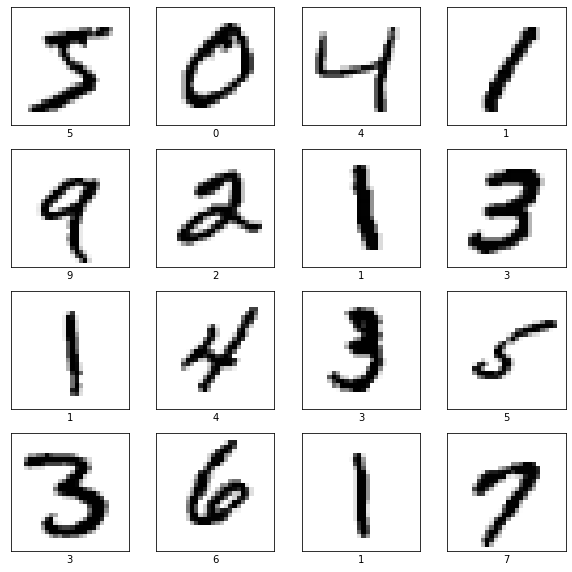

In [3]:
plt.figure(figsize = (10,10))

for i in range(0, 16) :
    plt.subplot(4, 4, i + 1)
    plt.imshow(x_train[i], cmap = 'binary')
    plt.xlabel(str(y_train[i]))
    plt.xticks([])
    plt.yticks([])

plt.show()

# Normalize Data

In [4]:
x_train = np.reshape(x_train, (60000, 28 * 28))
x_test = np.reshape(x_test, (10000, 28 * 28))

x_train = x_train / 255.
x_test  = x_test / 255.

# Create a Neural Network Model

In [5]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation = 'sigmoid', input_shape = (784,)),
    tf.keras.layers.Dense(32, activation = 'sigmoid'),
    tf.keras.layers.Dense(10, activation = 'softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

# Train the Model

In [6]:
_ = model.fit(
    x_train, y_train,
    validation_data = (x_test, y_test),
    epochs = 20, batch_size = 1024,
    verbose = 2
)

Epoch 1/20
59/59 - 1s - loss: 2.1656 - accuracy: 0.4266 - val_loss: 1.9702 - val_accuracy: 0.6655
Epoch 2/20
59/59 - 0s - loss: 1.7749 - accuracy: 0.6956 - val_loss: 1.5524 - val_accuracy: 0.7335
Epoch 3/20
59/59 - 0s - loss: 1.3723 - accuracy: 0.7526 - val_loss: 1.1827 - val_accuracy: 0.7835
Epoch 4/20
59/59 - 0s - loss: 1.0538 - accuracy: 0.8127 - val_loss: 0.9173 - val_accuracy: 0.8448
Epoch 5/20
59/59 - 0s - loss: 0.8304 - accuracy: 0.8569 - val_loss: 0.7321 - val_accuracy: 0.8707
Epoch 6/20
59/59 - 0s - loss: 0.6730 - accuracy: 0.8787 - val_loss: 0.6006 - val_accuracy: 0.8856
Epoch 7/20
59/59 - 0s - loss: 0.5610 - accuracy: 0.8911 - val_loss: 0.5080 - val_accuracy: 0.8952
Epoch 8/20
59/59 - 0s - loss: 0.4823 - accuracy: 0.8985 - val_loss: 0.4439 - val_accuracy: 0.9027
Epoch 9/20
59/59 - 0s - loss: 0.4261 - accuracy: 0.9052 - val_loss: 0.3981 - val_accuracy: 0.9085
Epoch 10/20
59/59 - 0s - loss: 0.3849 - accuracy: 0.9093 - val_loss: 0.3630 - val_accuracy: 0.9134
Epoch 11/20
59/59 -

# Save the Model

In [7]:
model.save('model.h5')

# ML Server

In [8]:
%%writefile ml_server.py

import json
import tensorflow as tf
import numpy as np
import random
from flask import Flask, request

app = Flask(__name__)

model = tf.keras.models.load_model('model.h5')
feature_model = tf.keras.models.Model(
    model.inputs,
    [layer.output for layer in model.layers]
)

_, (x_test, _) = tf.keras.datasets.mnist.load_data()
x_test = x_test / 255.

def get_prediction() :
    index = np.random.choice(x_test.shape[0])
    image = x_test[index, :, :]
    image_arr = np.reshape(image, (1, 784))
    return feature_model.predict(image_arr), image

@app.route('/', methods = ['GET', 'POST'])
def index() :
    if request.method == 'POST' :
        preds, image = get_prediction()
        final_preds = [p.tolist() for p in preds]
        return json.dumps({
            'prediction' : final_preds,
            'image' : image.tolist()
        })
    return 'Welcome to the Model Server!'

if __name__ == '__main__' :
    app.run()

Overwriting ml_server.py


# Streamlit Web App

In [9]:
%%writefile app.py

import streamlit as st
import json
import requests
import matplotlib.pyplot as plt
import numpy as np

URI = 'http://127.0.0.1:5000/'

st.title('Neural Network Visualizer')
st.sidebar.markdown(' ## Input Image')

if st.button('Get Random Prediction') :
    response = requests.post(URI, data = {})
    response = json.loads(response.text)
    preds = response.get('prediction')
    image = response.get('image')
    image = np.reshape(image, (28, 28))
    
    st.sidebar.image(image, width = 150)
    
    
    for layer, p in enumerate(preds) :
        numbers = np.squeeze(np.array(p))
        
        plt.figure(figsize = (32, 4))
        
        if layer == 2:
            row = 1
            col = 10
        else :
            row = 2
            col = 16
            
        for i, number in enumerate (numbers) :
            plt.subplot(row, col, i + 1)
            plt.imshow(number * np.ones((8, 8, 3)).astype('float32'), cmap = 'binary')
            plt.xticks([])
            plt.yticks([])
            
            if layer == 2:
                plt.xlabel(str(i), fontsize = 40)
                
        plt.subplots_adjust(wspace = 0.05, hspace = 0.05)
        plt.tight_layout()
        st.text('Layer {}'. format(layer + 1))
        st.pyplot()
                

Overwriting app.py
